In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from lib.functions import LogisticRegression
import lib.load_datasets as load_datasets
from lib.compressions import *
from lib.compressions import Compressor, SmartCompressor
from lib.gradient_descent import compressedGD, stochasticCompressedGD
from functools import partial

In [2]:
X, y = load_datasets.dataset_to_X_y('diabetes.csv', normalize=True, nrows=500)
#X, y = make_blobs(n_samples=500, centers=2, n_features=5, random_state=0)
function = LogisticRegression(X, y)
dim = function.getDimention()
alpha = 0.0001

In [3]:
base_experiments = [
    #compressedGD(function, name='Without', alpha=0.0001),
    #compressedGD(function, name='Top-k, k=d/3', compressor=Compressor(topK, k=dim//3), alpha=alpha),
    compressedGD(function, name='Top-k, k=d/2', compressor=Compressor(topK, k=dim//2), alpha=alpha),
    #compressedGD(function, name='Top-k, k=1', compressor=Compressor(topK, k=1), alpha=alpha),
    #compressedGD(function, name='Rand-k, k=d/3', compressor=Compressor(uniformCompression, k=dim//3), alpha=alpha),
    #compressedGD(function, name='Rand-k, k=1', compressor=Compressor(uniformCompression, k=1), alpha=alpha),
    stochasticCompressedGD(function, name='Ban 2 in a row, k=d/3', compressor=SmartCompressor(ban2InARow, k=dim//3), alpha=alpha),
    stochasticCompressedGD(function, name='Reduce probability, k=d/3, alpha=0.5', compressor=SmartCompressor(partial(reduceProbability, alpha=0.5), k=dim//3), alpha=alpha),
]

In [7]:
new_experiments = [
    #stochasticCompressedGD(function, name='Reduce probability with softmax, k=d/3, alpha=0.5', compressor=SmartCompressor(partial(reduceProbabilitySoftMax, alpha=0.5), k=dim//3), alpha=alpha),
    #stochasticCompressedGD(function, name='Reduce probability with softmax, k=d/3, alpha=0.3', compressor=SmartCompressor(partial(reduceProbabilitySoftMax, alpha=0.3), k=dim//3), alpha=alpha),
    #stochasticCompressedGD(function, name='Reduce probability with softmax, k=d/3, alpha=0.7', compressor=SmartCompressor(partial(reduceProbabilitySoftMax, alpha=0.7), k=dim//3), alpha=alpha),
]


In [8]:
experiments = base_experiments + new_experiments
experiments.sort(key=lambda exp : exp['k'] * exp['num_iter'])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['k'] * exp['num_iter']]
        for exp in experiments
    ]
]
print(tabulate(table))

------------------------------------  --------  -----------------------
compression                           num_iter  transmitted coordinates
Top-k, k=d/2                          3321      13284
Reduce probability, k=d/3, alpha=0.5  4608      13824
Ban 2 in a row, k=d/3                 5366      16098
------------------------------------  --------  -----------------------


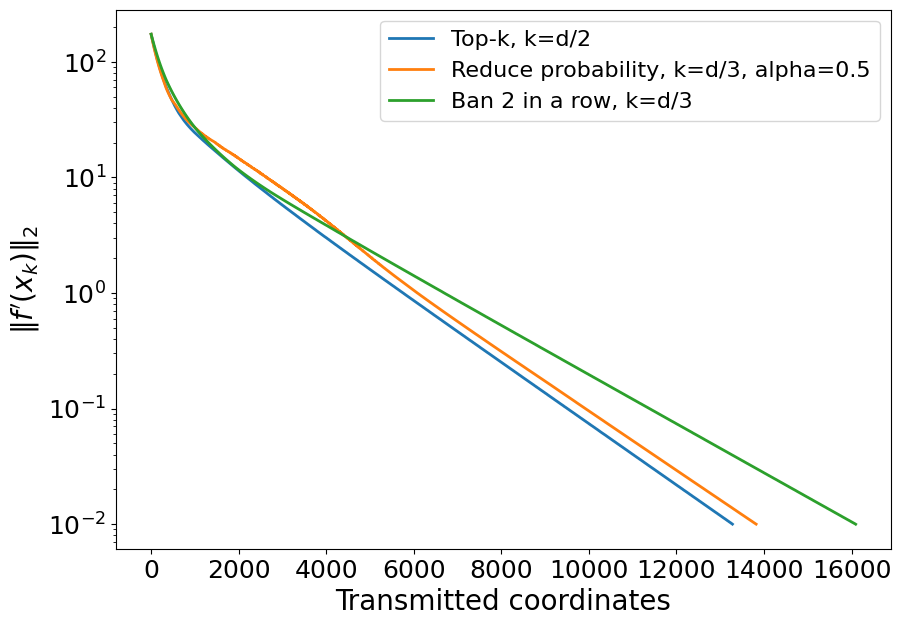

In [9]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [grad_norm for grad_norm in exp['gradients']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)